## Vanilla OLS

Say we've got a dataset

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
from yellowbrick.datasets import load_bikeshare

X, y = load_bikeshare()

Where we measure the number of DC-area bikes rented

In [3]:
y.head()

0    16
1    40
2    32
3    13
4     1
Name: riders, dtype: int64

Based on a number of features

In [4]:
X.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feelslike,humidity,windspeed
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


And just shoving everything into a Logistic Regression seems to work... alright

In [5]:
from statsmodels.api import OLS
import statsmodels.api as sm

X_const = sm.add_constant(X)
model = OLS(y, X_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 riders   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     920.8
Date:                Thu, 12 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:39:26   Log-Likelihood:            -1.1076e+05
No. Observations:               17379   AIC:                         2.216e+05
Df Residuals:                   17366   BIC:                         2.217e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.7573      7.057     -3.650      0.000     -39.590     -11.925
season        19.8993      1.819     10.941      0.000      16.334      23.464
year          81.0872      2.164     37.463      0.000      76.845      85.330
month         -0.0086      0.567     -0.015      0.988      -1.120       1.103
hour           7.6706      0.165     46.513      0.000       7.347       7.994
holiday      -21.8792      6.694     -3.268      0.001     -35.001      -8.758
weekday        1.8784      0.541      3.474      0.001       0.819       2.938
workingday     3.9392      2.396      1.644      0.100      -0.756       8.635
weather       -3.4321      1.905     -1.802      0.072      -7.165       0.301
temp          78.1498     36.957      2.115      0.034       5.710     150.590
feelslike    233.1571     41.517      5.616      0.000     151.779     314.535
humidity    -198.1847      6.889    -28.770      0.000    -211.687    -184.682
windspeed     41.5652      9.628      4.317      0.000      22.692      60.438
==============================================================================
Omnibus:                     3417.855   Durbin-Watson:                   0.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6659.872
Skew:                           1.198   Prob(JB):                         0.00
Kurtosis:                       4.859   Cond. No.                         787.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

But at the same time, have good reason to believe that there's some colinearity/interaction at play with our features.

C:\Users\Nick\Anaconda3\lib\site-packages\yellowbrick\features\rankd.py:215: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


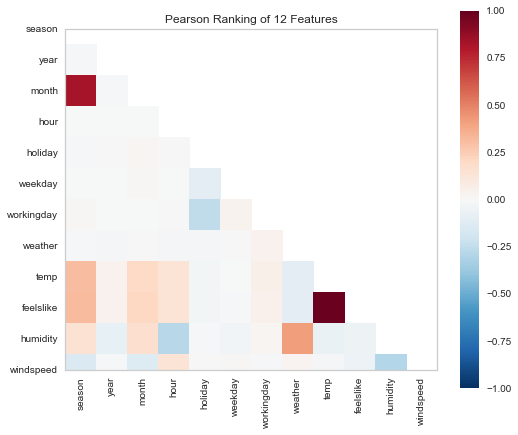

In [6]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm='pearson', size=(600, 500))
visualizer.fit_transform(X)
visualizer.poof();

## Interaction Terms 

From here, a good data scientist will take the time to do exploratory analysis and thoughtful feature engineering-- this is the "More Art than Science" adage you hear so often.

But we're trying to be home by 5, so how do we cram everything in and see what shakes out?

### Getting Values
Thankfully, the `PolynomialFeatures` object in `sklearn` has us mostly-covered.

It's originally used to generate sequences of `(b_i1 * x_i) + (b_i2 * x_i^2) + ...` for each feature in `X`, taking us from `n` features to `2^n` features (in the case of `PolynomialFeatures(degree=2)`, anyhow).

We're not interested in polynomials, per se, but if you squint, the same `itertools` magic™ that powers the backend of this can also be used to provide all pairwise feature combinations, with minimal rewriting. They provide this, ez pz, with the `interaction_only` flag.

And so we go from

In [7]:
X.shape

(17379, 12)

To an expected $\frac{p * (p - 1)}{2}$ pairs, plus our original `p` features, plus a bias term

In [8]:
p = len(X.columns)
(p * (p-1)) / 2 + p + 1

79.0

Coolio

In [9]:
from sklearn.preprocessing import PolynomialFeatures

interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = interaction.fit_transform(X)
X_inter_const = sm.add_constant(X_inter)

X_inter_const.shape

(17379, 79)

Now we brazenly throw it into a new model, and... oh. A lot of features called `x`

In [10]:
model = OLS(y, X_inter_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 riders   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     183.2
Date:                Thu, 12 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:39:26   Log-Likelihood:            -1.0986e+05
No. Observations:               17379   AIC:                         2.199e+05
Df Residuals:                   17301   BIC:                         2.205e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.9215     31.348     -0.412      0.680     -74.367      48.524
x1             4.8668     13.591      0.358      0.720     -21.773      31.506
x2             1.5025     13.709      0.110      0.913     -25.368      28.373
x3            -5.6567      3.650     -1.550      0.121     -12.811       1.497
x4            -1.5711      1.010     -1.555      0.120      -3.551       0.409
x5           -53.5016     42.280     -1.265      0.206    -136.374      29.371
x6            -5.8416      3.221     -1.814      0.070     -12.155       0.471
x7           -59.3405     14.670     -4.045      0.000     -88.095     -30.586
x8            24.8815     12.260      2.030      0.042       0.851      48.912
x9           967.3801    242.465      3.990      0.000     492.123    1442.637
x10         -398.7968    267.389     -1.491      0.136    -922.906     125.313
x11           29.5847     38.027      0.778      0.437     -44.953     104.122
x12         -174.6887     55.839     -3.128      0.002    -284.138     -65.239
x13           -2.0902      3.782     -0.553      0.580      -9.503       5.322
x14            1.9024      0.528      3.600      0.000       0.867       2.938
x15            0.7962      0.259      3.071      0.002       0.288       1.304
x16           10.7146      8.522      1.257      0.209      -5.990      27.419
x17            0.8804      0.890      0.989      0.323      -0.864       2.625
x18           -3.3540      3.979     -0.843      0.399     -11.152       4.444
x19            5.1034      3.100      1.646      0.100      -0.972      11.179
x20         -224.2428     86.181     -2.602      0.009    -393.166     -55.320
x21          175.4640     94.973      1.848      0.065     -10.693     361.621
x22          -20.6737     12.747     -1.622      0.105     -45.659       4.312
x23           27.4909     16.320      1.685      0.092      -4.497      59.479
x24            2.0389      1.193      1.709      0.087      -0.299       4.377
x25            2.7809      0.318      8.752      0.000       2.158       3.404
x26          -10.2711     13.890     -0.739      0.460     -37.497      16.955
x27            3.0712      1.047      2.932      0.003       1.018       5.124
x28           18.9473      4.631      4.092      0.000       9.870      28.024
x29            1.8761      3.686      0.509      0.611      -5.349       9.101
x30         -157.1947     81.641     -1.925      0.054    -317.219       2.830
x31          281.8987     91.747      3.073      0.002     102.066     461.731
x32          -86.9838     13.435     -6.475      0.000    -113.317     -60.650
x33           56.9213     18.839      3.021      0.003      19.995      93.848
x34           -0.1121      0.081     -1.390      0.165      -0.270       0.046
x35           -2.2869      2.442     -0.937      0.349      -7.073       2.499
x3

### Feature Names?

The `interaction` object keeps track of the names of our feature combinations... sort of

In [11]:
print(interaction.get_feature_names())

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x8 x9', 'x8 x10', 'x8 x11', 'x9 x10', 'x9 x11', 'x10 x11']


Assuming that a bevy of `xi xj`s aren't much more useful than the output of `model.summary()` we can do some hacky, Python nonsense to decode a bit.

For starters, we want to create a dictionary that maps `xi` to its corresponding feature name in our dataset.

We'll use the `itertools.count()` function, as it's basically `enumerate`, but plays better with generator expressions.

In [12]:
from itertools import count

x_to_feature = dict(zip(('x{}'.format(i) for i in count()), X.columns))
x_to_feature

{'x0': 'season',
 'x1': 'year',
 'x2': 'month',
 'x3': 'hour',
 'x4': 'holiday',
 'x5': 'weekday',
 'x6': 'workingday',
 'x7': 'weather',
 'x8': 'temp',
 'x9': 'feelslike',
 'x10': 'humidity',
 'x11': 'windspeed'}

Next, you know it's Sound Data Science™ when we break out

In [13]:
import re

Finally, this [little diddy](https://www.youtube.com/watch?v=9VBSH-2fMuw) goes through and makes the appropriate substitutions for `xi` to their respective feature names, then replaces spaces with underscores so `pandas` references isn't such a chore

In [14]:
# necessary so `x11` gets a chance to swap before 
# before `x1` leaves us with "season1" where we wanted
# "windspeed"
feature_keys = list(x_to_feature.keys())[::-1]

features = []

for feature in interaction.get_feature_names():
    for key in feature_keys:
        feature_name = x_to_feature[key]
        feature = re.sub(key, feature_name, feature)
    feature = re.sub(' ', '_', feature)
    features.append(feature)

Then we'll slap these feature names onto our big ol' dataset

In [15]:
import pandas as pd
import statsmodels.api as sm

X_all_inter = pd.DataFrame(X_inter, columns=features)
X_all_inter_const = sm.add_constant(X_all_inter)

And refit

In [16]:
model = OLS(y, X_all_inter_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 riders   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     183.2
Date:                Thu, 12 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:39:27   Log-Likelihood:            -1.0986e+05
No. Observations:               17379   AIC:                         2.199e+05
Df Residuals:                   17301   BIC:                         2.205e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -12.9215     31.348     -0.412      0.680     -74.367      48.524
season                   4.8668     13.591      0.358      0.720     -21.773      31.506
year                     1.5025     13.709      0.110      0.913     -25.368      28.373
month                   -5.6567      3.650     -1.550      0.121     -12.811       1.497
hour                    -1.5711      1.010     -1.555      0.120      -3.551       0.409
holiday                -53.5016     42.280     -1.265      0.206    -136.374      29.371
weekday                 -5.8416      3.221     -1.814      0.070     -12.155       0.471
workingday             -59.3405     14.670     -4.045      0.000     -88.095     -30.586
weather                 24.8815     12.260      2.030      0.042       0.851      48.912
temp                   967.3801    242.465      3.990      0.000     492.123    1442.637
feelslike             -398.7968    267.389     -1.491      0.136    -922.906     125.313
humidity                29.5847     38.027      0.778      0.437     -44.953     104.122
windspeed             -174.6887     55.839     -3.128      0.002    -284.138     -65.239
season_year             -2.0902      3.782     -0.553      0.580      -9.503       5.322
season_month             1.9024      0.528      3.600      0.000       0.867       2.938
season_hour              0.7962      0.259      3.071      0.002       0.288       1.304
season_holiday          10.7146      8.522      1.257      0.209      -5.990      27.419
season_weekday           0.8804      0.890      0.989      0.323      -0.864       2.625
season_workingday       -3.3540      3.979     -0.843      0.399     -11.152       4.444
season_weather           5.1034      3.100      1.646      0.100      -0.972      11.179
season_temp           -224.2428     86.181     -2.602      0.009    -393.166     -55.320
season_feelslike       175.4640     94.973      1.848      0.065     -10.693     361.621
season_humidity        -20.6737     12.747     -1.622      0.105     -45.659       4.312
season_windspeed        27.4909     16.320      1.685      0.092      -4.497      59.479
year_month               2.0389      1.193      1.709      0.087      -0.299       4.377
year_hour                2.7809      0.318      8.752      0.000       2.158       3.404
year_holiday           -10.2711     13.890     -0.739      0.460     -37.497      16.955
year_weekday             3.0712      1.047      2.932      0.003       1.018       5.124
year_workingday         18.9473      4.631      4.092      0.000       9.870      28.024
year_weather             1.8761      3.686      0.509      0.611      -5.349       9.101
year_temp             -157.1947     81.641     -1.925      0.054    -317.219       2.830
year_feelslike         281.8987     91.747      3.073    

### And that's Data Science!

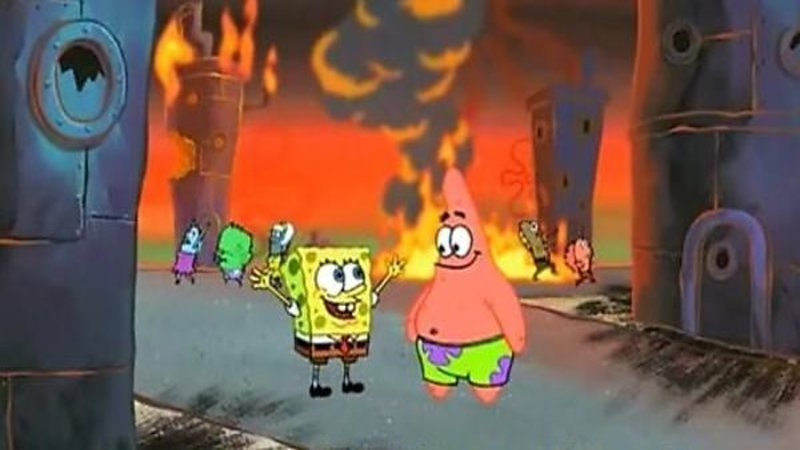

In [17]:
from IPython.display import Image
Image('images/we_did_it.jpg')